<a href="https://colab.research.google.com/github/marcojr93/data-science-portifolio/blob/main/Pump_failure_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Industry pump failure analysis

The main point of this project is create an algorithm to reconize failure based on pump sensors information and predict status

## Libraries and database

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

In [87]:
df = pd.read_excel('pump_data.xlsx')

In [88]:
df.head()

,Timestamp,motor_current,flow,vibration,temperature
0,2021-12-01 00:00:00,259.100006,292.762756,0.878293,67.017143
1,2021-12-01 00:01:00,259.100006,287.605286,0.873565,67.068176
2,2021-12-01 00:02:00,259.800018,297.546387,0.895125,67.068176
3,2021-12-01 00:03:00,258.399994,292.648315,0.885101,67.072105
4,2021-12-01 00:04:00,258.399994,290.847778,0.885101,67.017143


In [89]:
print('This is a monthly database with a total of {} elements'.format((df.shape[0])))

This is a monthly database with a total of 50401 elements


## Exploratory data analysis

In [90]:
df.describe()

,motor_current,flow,vibration,temperature
count,50401.000000,50401.000000,50401.000000,50401.000000
mean,188.853606,198.879044,0.663894,59.343060
std,110.031915,117.963313,0.378544,12.581283
min,0.000000,0.000000,0.000000,34.841057
25%,0.300000,0.000000,0.015130,59.577698
50%,248.800003,256.401062,0.872808,64.500687
75%,256.200012,280.998230,0.891531,68.049637
max,1700.000000,392.417877,1.963352,207.279114


The maximum 'motor_currente' value indicates that we can have two situations:

1.   Equipment startup - The equipment will operate with 6 to 7x the nominal value (250 A)
2.   Issue - if this value stands and oder variables increase their value, it may be an issue such as bearing or housing problems



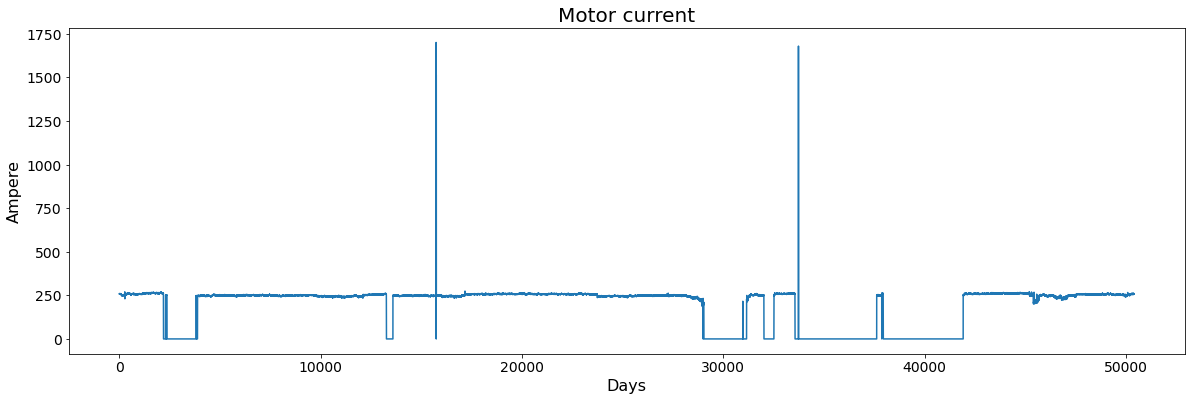

In [91]:
# Take a look at the current values

fig, ax = plt.subplots(figsize=(20,6))
ax.set_title('Motor current', fontsize=20)
ax.set_ylabel('Ampere', fontsize=16)
ax.set_xlabel('Days', fontsize=16)
ax = df['motor_current'].plot(fontsize=14)

The biggest value at the graph can be a failure cause after this point, we see that the equipment shut down.

Necessary analyse if the vibration increase above the recomendation point (ISO 10816).

Our equipment belongs to Class III

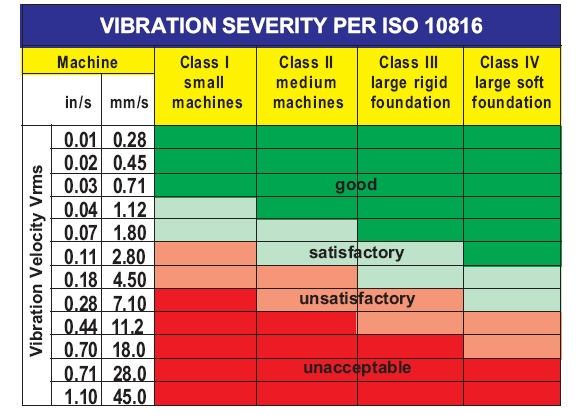

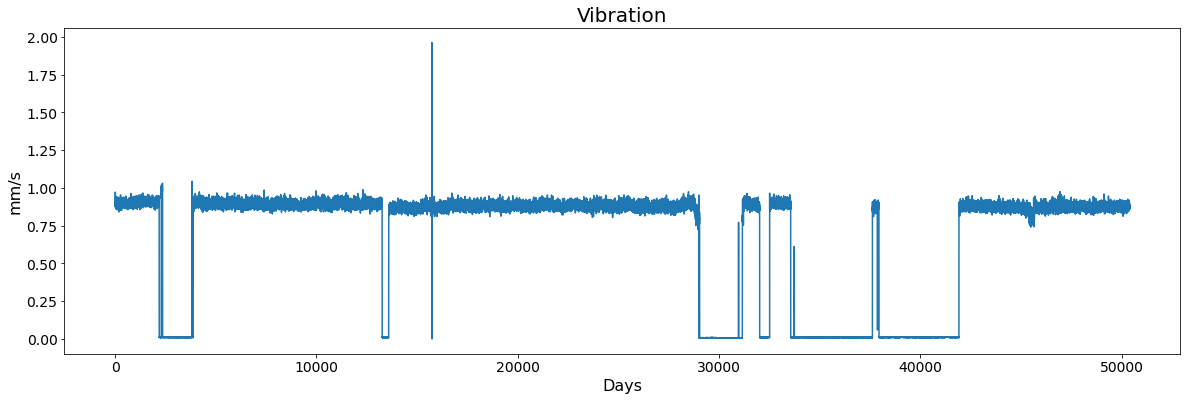

In [92]:
fig, ax = plt.subplots(figsize=(20,6))
ax.set_title('Vibration', fontsize=20)
ax.set_ylabel('mm/s', fontsize=16)
ax.set_xlabel('Days', fontsize=16)
ax = df['vibration'].plot(fontsize=14)

As we can see, the vibration stands, so it can be concluded that wasn't a failure. So, we need to teach or algorithm to reconize that it can be a startup moment

## Failure classification

In [205]:
# Motor current setpoint
current_setpoint = 1500

def classifier(x):

  if (x['motor_current']) > current_setpoint:
    if (x['vibration']) < 1.8:
      return "startup" # Startup machine
    elif (x['vibration']) > 1.8:
      return "alert" # Failure alert
  else:
    return "normal" # Normal opreation

df['status'] = df.apply(classifier, axis = 1)
df.head()

,motor_current,flow,vibration,temperature,status
0,259.100006,292.762756,0.878293,67.017143,normal
1,259.100006,287.605286,0.873565,67.068176,normal
2,259.800018,297.546387,0.895125,67.068176,normal
3,258.399994,292.648315,0.885101,67.072105,normal
4,258.399994,290.847778,0.885101,67.017143,normal


In [206]:
df['status'].value_counts()

normal     50397
startup        3
alert          1
Name: status, dtype: int64

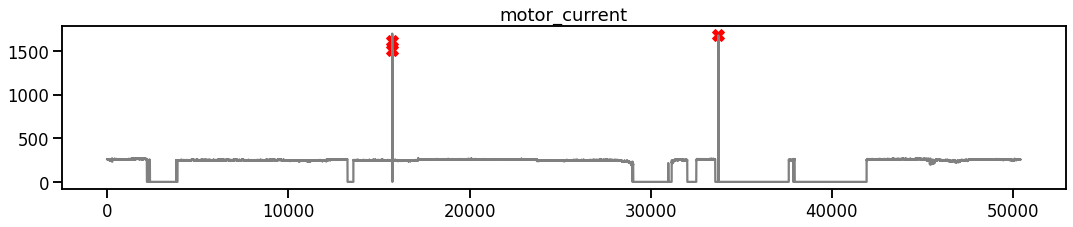

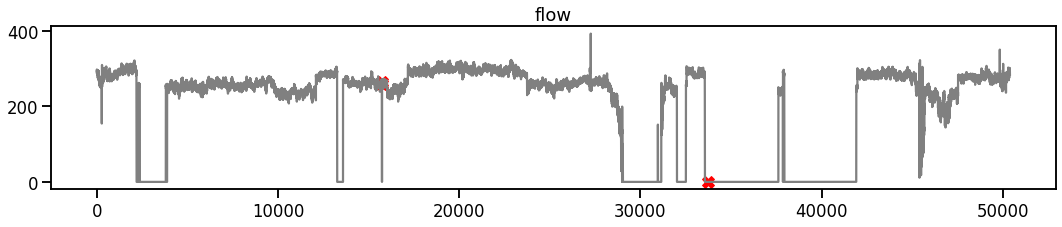

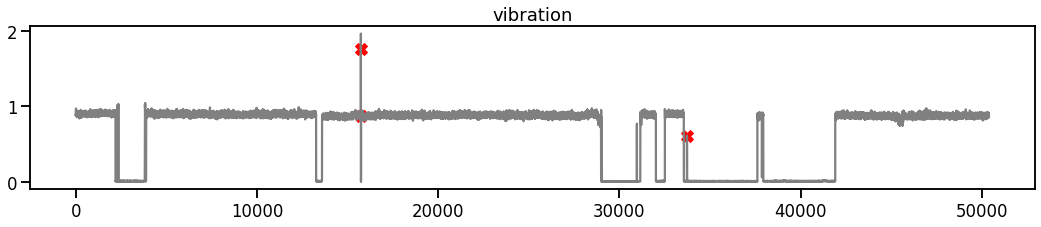

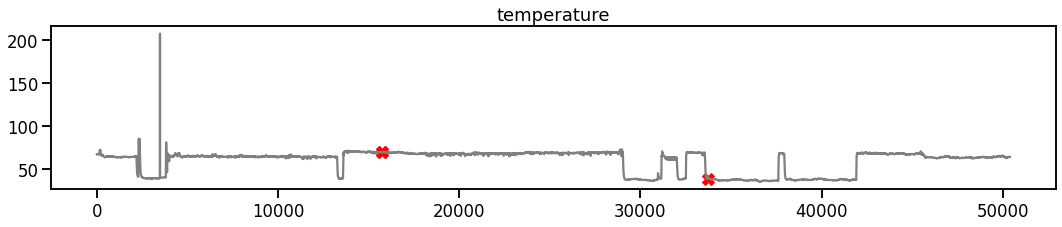

In [172]:
dfStartup = df[df['status']=='startup'] 
dfSensors = df.drop(['status'], axis=1) 
sensorNames=dfSensors.columns 

for sensor in sensorNames:
    sns.set_context('talk')
    _ = plt.figure(figsize=(18,3))
    _ = plt.plot(dfStartup[sensor], linestyle='none', marker='X', color='red', markersize=12)
    _ = plt.plot(df[sensor], color='grey')
    _ = plt.title(sensor)
    plt.show()

In [154]:
df = df.drop(['Timestamp'], axis = 1)

## Prediction model

### Classification - Random Foerest

In [174]:
# Train and test split dataset

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y = df['status']
X = df[['motor_current', 'vibration', 'flow', 'temperature']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [175]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X,y)

RandomForestClassifier()

In [176]:
y_pred = model.predict(X_test)
y_pred

array(['normal', 'normal', 'normal', ..., 'normal', 'normal', 'normal'],
      dtype=object)

In [177]:
accuracy = metrics.accuracy_score(y_test, y_pred)
print("The model accuracy is {} %".format(accuracy*100))

The model accuracy is 100.0 %


#### Manual testing

In [178]:
columns = X_test.columns.to_list()
input = X_test[0:1]

In [179]:
line = df.iloc[[0]]
line # This is the line that will be used for testing

,motor_current,flow,vibration,temperature,status
0,259.100006,292.762756,0.878293,67.017143,normal


In [182]:
# Coping the line above to change some variables in order to evaluate models accuracy 
line2 = line.copy() 

In [185]:
# Case 1 - For this condition bellow is expected that the model identify a "startup" status
line2['vibration'] = 1.8
line2['motor_current'] = 1800
line2_pred = model.predict(line2[columns])
print(line2_pred)

['startup']


In [187]:
# Case 2 - For this condition bellow is expected that the model identify an "alert" status
line2['vibration'] = 1.9
line2['motor_current'] = 1800
line2_pred = model.predict(line2[columns])
print(line2_pred)

['alert']


In [192]:
# Case 3 - For this condition bellow is expected that the model identify a "normal" status
line2['vibration'] = 1.8
line2['motor_current'] = 250
line2_pred = model.predict(line2[columns])
print(line2_pred)

['normal']
